In [ ]:
!pip install gplearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gplearn
import statsmodels.api as sm

     |████████████████████████████████| 51kB 2.7MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Loading the data

In [ ]:
#load the data
data = pd.read_excel('/content/gdrive/My Drive/MMM/MARKETING DATA.xlsx')
data.columns

Index(['time.index', 'tv.volume', 'tv.spend', 'search.clicks', 'search.imps',
       'display.budget', 'search.budget', 'search.spend', 'total.spend',
       'search.matching.query.volume', 'search.query.volume', 'brand.sales',
       'competitor.sales', 'revenue', 'profit', 'tv.budget.index', 'tv.budget',
       'search.budget.index', 'search.budget.1', 'Unnamed: 19'],
      dtype='object')

Checking null values

In [ ]:
#checking null values
data.isnull().any()


time.index                      False
tv.volume                       False
tv.spend                        False
search.clicks                   False
search.imps                     False
display.budget                  False
search.budget                   False
search.spend                    False
total.spend                     False
search.matching.query.volume    False
search.query.volume             False
brand.sales                     False
competitor.sales                False
revenue                         False
profit                          False
tv.budget.index                 False
tv.budget                       False
search.budget.index             False
search.budget.1                 False
Unnamed: 19                      True
dtype: bool

Checking zero values. Although there are a few columns with zeros, there are no zeros all those columns together, at the same time.

In [ ]:
#checking zeros
(data == 0).any()

time.index                      False
tv.volume                        True
tv.spend                         True
search.clicks                    True
search.imps                      True
display.budget                   True
search.budget                    True
search.spend                     True
total.spend                      True
search.matching.query.volume    False
search.query.volume             False
brand.sales                     False
competitor.sales                False
revenue                         False
profit                          False
tv.budget.index                 False
tv.budget                       False
search.budget.index             False
search.budget.1                 False
Unnamed: 19                     False
dtype: bool

In [ ]:
data.head(5)

,time.index,tv.volume,tv.spend,search.clicks,search.imps,display.budget,search.budget,search.spend,total.spend,search.matching.query.volume,search.query.volume,brand.sales,competitor.sales,revenue,profit,tv.budget.index,tv.budget,search.budget.index,search.budget.1,Unnamed: 19
0,1,0,0.000000e+00,0,0,0.00000,0.0,0.0,0.000000e+00,2178598,19358848,1652952,9189596,132236160,1.322362e+08,1,54500000,1,6000000,NaN
1,2,671176538,3.355871e+06,183899,2336393,110347.84139,91949.5,202288.9,3.558160e+06,2336393,20767242,1942495,9831554,155399600,1.518414e+08,1,54500000,1,6000000,NaN
2,3,0,0.000000e+00,162984,2092627,98834.77321,81492.0,179282.4,1.792824e+05,2092627,18589882,1579585,8777439,126366800,1.261875e+08,1,54500000,1,6000000,NaN
3,4,0,0.000000e+00,143584,1872071,88417.91333,71792.0,157942.4,1.579424e+05,1872071,16617808,1386392,7720425,110911360,1.107534e+08,1,54500000,1,6000000,NaN
4,5,0,0.000000e+00,137564,1804398,85221.71754,68782.0,151320.4,1.513204e+05,1804398,16047854,1333346,7412018,106667680,1.065164e+08,1,54500000,1,6000000,NaN


Reviewing the data, we could see that the last 4 columns do not have any valuable information, they resemble a fixed GL account for budgeting purposes.

In [ ]:
#dropping the last four coloumns since they are not informative, probably they budget GL account or similar.
cols_to_drop = ['tv.budget.index', 'tv.budget','search.budget.index', 'search.budget.1']
data.drop(cols_to_drop, axis = 1, inplace = True)

Since the numbers are too big and there are a few float data types, we are converting to integer to make it easier to work.

In [ ]:
#rounding the numbers
data = round(data,)
data['tv.spend'] = data['tv.spend'].astype(int)
data['display.budget'] = data['display.budget'].astype(int)
data['search.budget'] = data['search.budget'].astype(int)
data['search.spend '] = data['search.spend'].astype(int)
data['total.spend'] = data['total.spend'].astype(int)
data['profit'] = data['profit'].astype(int)
data.head()

,time.index,tv.volume,tv.spend,search.clicks,search.imps,display.budget,search.budget,search.spend,total.spend,search.matching.query.volume,search.query.volume,brand.sales,competitor.sales,revenue,profit,Unnamed: 19,search.spend
0,1,0,0,0,0,0,0,0.0,0,2178598,19358848,1652952,9189596,132236160,132236160,NaN,0
1,2,671176538,3355871,183899,2336393,110348,91950,202289.0,3558160,2336393,20767242,1942495,9831554,155399600,151841440,NaN,202289
2,3,0,0,162984,2092627,98835,81492,179282.0,179282,2092627,18589882,1579585,8777439,126366800,126187518,NaN,179282
3,4,0,0,143584,1872071,88418,71792,157942.0,157942,1872071,16617808,1386392,7720425,110911360,110753418,NaN,157942
4,5,0,0,137564,1804398,85222,68782,151320.0,151320,1804398,16047854,1333346,7412018,106667680,106516360,NaN,151320


Basic statistics to understand the data

In [ ]:
#statistics in thousandths for numerical variables
round(data.describe()/1000)

,time.index,tv.volume,tv.spend,search.clicks,search.imps,display.budget,search.budget,search.spend,total.spend,search.matching.query.volume,search.query.volume,brand.sales,competitor.sales,revenue,profit,Unnamed: 19,search.spend
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,182210.0,911.0,266.0,3536.0,167.0,126.0,293.0,1204.0,4187.0,14798.0,1249.0,6713.0,99957.0,98753.0,642057.0,293.0
std,0.0,279310.0,1397.0,199.0,2551.0,121.0,99.0,219.0,1420.0,2256.0,3848.0,397.0,2078.0,31725.0,31306.0,NaN,219.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,976.0,8498.0,611.0,3284.0,48885.0,48885.0,642057.0,0.0
25%,0.0,0.0,0.0,108.0,1472.0,70.0,48.0,118.0,203.0,2214.0,11380.0,899.0,4884.0,71947.0,71118.0,642057.0,118.0
50%,0.0,0.0,0.0,256.0,3494.0,165.0,111.0,282.0,535.0,4100.0,14431.0,1197.0,6536.0,95729.0,95099.0,642057.0,282.0
75%,0.0,325772.0,1629.0,382.0,5199.0,246.0,182.0,420.0,2074.0,5581.0,18197.0,1591.0,8581.0,127276.0,126085.0,642057.0,420.0
max,0.0,1339682.0,6699.0,827.0,10332.0,488.0,422.0,910.0,6869.0,10332.0,22964.0,2148.0,11210.0,171813.0,169568.0,642057.0,910.0


Plotting correlation between the variables to understand multi-collinearity and possible implications into modelling.

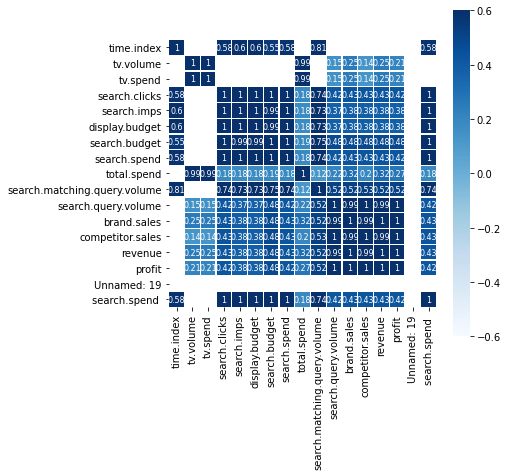

In [ ]:
#Correlation between the variables, many variables are correlated (such as revenue, profit, brand sales etc) and its important to exclude those from the mode
corr = data.corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)],
           cmap = 'Blues', vmax = 0.6, vmin = -0.6, linewidths = 0.1,
           annot = True, annot_kws = {"size":8}, square = True)

Plotting scatter plot for marketing investment and revenue.

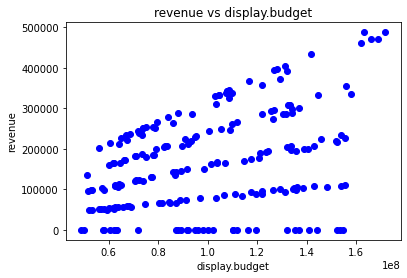

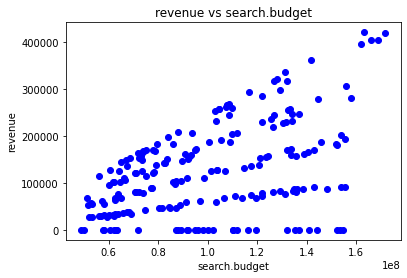

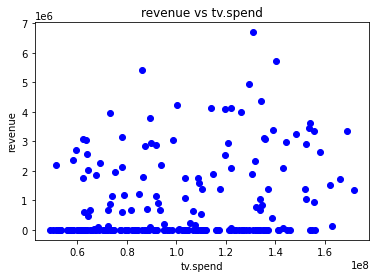

In [ ]:
#labels and features
label = data['revenue']
features = data[['display.budget','search.budget','tv.spend']]

#scatter plot between revenue and marketing expenditures
for x in features:
    plt.plot(label, features[x], 'bo') 
    plt.title("revenue vs " + x)
    plt.xlabel(x)
    plt.ylabel("revenue")
    plt.show()

Plotting histograms to understand distribution for 3 types of marketing investment.

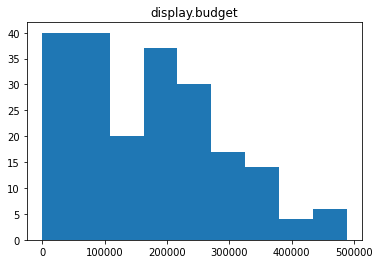

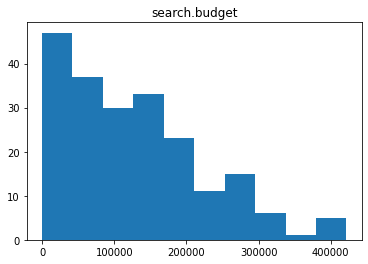

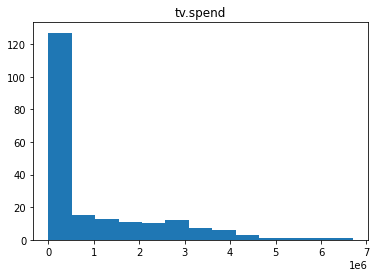

In [ ]:
#data distribution for marketing investment variables
for x in features:
    plt.hist(features[x], bins='auto')  
    plt.title(x)
    plt.show()

Checking outliers since they impact the model, we see outliers in tv spend and search budget.

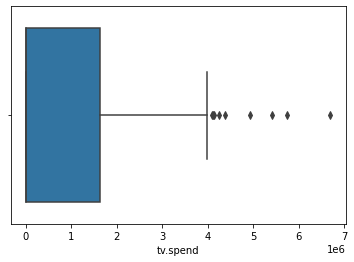

In [ ]:
#Identify outliers in marketing expenditure
import seaborn as sns
sns.boxplot(x=data['tv.spend'])


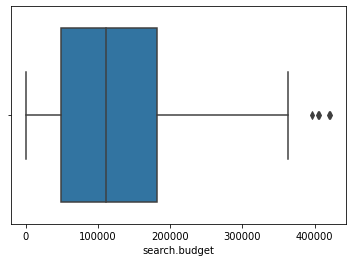

In [ ]:
sns.boxplot(x=data['search.budget'])

We tried removing outliers and although the model significantly improves after the removal, financials do not make sense due to the synthetic data. We decided to keep the outliers since the current model already shows high level of accuracy.

In [ ]:
#Removing outliers for tv spend and search budget
#P = np.percentile(data['tv.spend'], [5, 95])
#P1 = np.percentile(data['search.budget'], [5, 95])
#data = data[(data['tv.spend'] > P[0]) & (data['tv.spend'] < P[1])& (data['search.budget'] > P1[0]) & (data['search.budget'] < P1[1])]


Regression with one variable at a time to understand the relationship.

In [ ]:
#Linear regression with only investment variable display budget
X = data[['display.budget']]
y = data["revenue"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                              499.1
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.58e-57
Time:                        08:40:36   Log-Likelihood:                         -4008.9
No. Observations:                 208   AIC:                                      8020.
Df Residuals:                     207   BIC:                                      8023.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
display.budget   428.3686     19.174     22.341      0.000     390.568     466.170
==============================================================================
Omnibus:                       10.975   Durbin-Watson:                   0.466
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                9.769
Skew:                           0.459   Prob(JB):                      0.00756
Kurtosis:                       2.467   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Linear regression with only investment variable search budget
X = data[['search.budget']]
y = data["revenue"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                              498.8
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.82e-57
Time:                        08:40:36   Log-Likelihood:                         -4008.9
No. Observations:                 208   AIC:                                      8020.
Df Residuals:                     207   BIC:                                      8023.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
search.budget   551.7312     24.704     22.334      0.000     503.027     600.435
==============================================================================
Omnibus:                        4.736   Durbin-Watson:                   0.470
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                4.785
Skew:                           0.344   Prob(JB):                       0.0914
Kurtosis:                       2.718   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Linear regression with only investment variable tv spend
X = data[['tv.spend']]
y = data["revenue"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.343
Model:                            OLS   Adj. R-squared (uncentered):              0.340
Method:                 Least Squares   F-statistic:                              108.3
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    1.16e-20
Time:                        08:40:36   Log-Likelihood:                         -4092.7
No. Observations:                 208   AIC:                                      8187.
Df Residuals:                     207   BIC:                                      8191.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tv.spend      36.9086      3.547     10.404      0.000      29.915      43.902
==============================================================================
Omnibus:                       25.642   Durbin-Watson:                   0.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.144
Skew:                          -0.877   Prob(JB):                     1.73e-07
Kurtosis:                       3.719   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regression with all 3 investment variables, with different confidence levels (high, medium, low)

In [ ]:
#Regression with all three investments
X = data[['tv.spend','search.budget','display.budget']]
y = data["revenue"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                              217.5
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    1.99e-63
Time:                        08:40:36   Log-Likelihood:                         -3987.7
No. Observations:                 208   AIC:                                      7981.
Df Residuals:                     205   BIC:                                      7991.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
tv.spend          16.2149      2.417      6.708      0.000      11.449      20.981
search.budget    311.9624    231.080      1.350      0.178    -143.636     767.561
display.budget   127.5573    179.851      0.709      0.479    -227.037     482.152
==============================================================================
Omnibus:                        4.389   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.140
Skew:                           0.342   Prob(JB):                        0.126
Kurtosis:                       3.093   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([ 6.,  3., 18., 18., 42., 54., 30., 28.,  6.,  3.]),
 array([-1.54844560e+08, -1.30110416e+08, -1.05376271e+08, -8.06421270e+07,
        -5.59079827e+07, -3.11738383e+07, -6.43969400e+06,  1.82944503e+07,
         4.30285947e+07,  6.77627390e+07,  9.24968833e+07]),
 <a list of 10 Patch objects>)

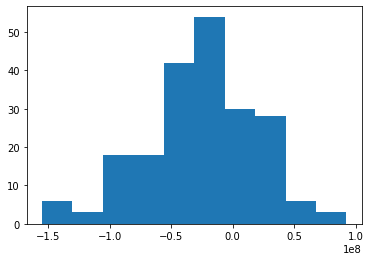

In [ ]:
#histogram of error
plt.hist(predictions - y)

Testing the regression to see the robustness of the model.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

data1 = data[['tv.spend','display.budget', 'search.budget']]
X_train,X_test,y_train,y_test = train_test_split(data1,data["revenue"].values,test_size=0.2,random_state = 1)
#Train the model using the training sets
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
#Predict Output
predictions = regressor.predict(X_test)
df_o1 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
rmse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(r2)



0.6556324540454421


We tried genetic algorithm to create feature as an interaction of variables but it did not improve the model so we decided to keep the model simple and explainable.

In [ ]:
#Genetic algorithm for feature interaction
!pip install gplearn
from gplearn.genetic import SymbolicRegressor

X_train,X_test,y_train,y_test = train_test_split(data1,data['revenue'],test_size=0.2,random_state = 1)

est_gp = SymbolicRegressor(population_size=50,
                           generations=5, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=0,
                           parsimony_coefficient=0.01, random_state=0, feature_names = X_train.columns)
est_gp.fit(X_train, y_train)
print(est_gp._program)



sub(sub(div(tv.spend, 0.079), sub(display.budget, div(tv.spend, 0.114))), sub(display.budget, div(tv.spend, 0.114)))


In [ ]:
#Creating feature based on GA suggestion
data1['GA']=30*data1['tv.spend']-2*data1['display.budget']
data1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tv.spend,display.budget,search.budget,GA
0,0,0,0,0
1,3355871,110348,91950,100455434
2,0,98835,81492,-197670
3,0,88418,71792,-176836
4,0,85222,68782,-170444
...,...,...,...,...
203,4933228,371939,298054,147252962
204,0,345031,267668,-690062
205,2095055,358304,285335,62135042
206,0,405802,336300,-811604


In [ ]:
#Feature created by GA did not improve the model
X_train,X_test,y_train,y_test = train_test_split(data1,data["revenue"].values,test_size=0.2,random_state = 1)
#Train the model using the training sets
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
#Predict Output
predictions = regressor.predict(X_test)
df_o1 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
rmse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(r2)

0.6556324540453256


Splitting the data into different years since budgeting is done on a yearly basis.

In [ ]:
year1=data.iloc[0:52]
year2=data.iloc[52:104]
year3=data.iloc[104:156]
year4=data.iloc[156:208]


In [ ]:

data.loc[0:52,'year'] = 'year1'
data.loc[52:104,'year'] = 'year2'
data.loc[104:156,'year'] = 'year3'
data.loc[156:208,'year'] = 'year4'
data.head(5)

,time.index,tv.volume,tv.spend,search.clicks,search.imps,display.budget,search.budget,search.spend,total.spend,search.matching.query.volume,search.query.volume,brand.sales,competitor.sales,revenue,profit,Unnamed: 19,search.spend,year
0,1,0,0,0,0,0,0,0.0,0,2178598,19358848,1652952,9189596,132236160,132236160,NaN,0,year1
1,2,671176538,3355871,183899,2336393,110348,91950,202289.0,3558160,2336393,20767242,1942495,9831554,155399600,151841440,NaN,202289,year1
2,3,0,0,162984,2092627,98835,81492,179282.0,179282,2092627,18589882,1579585,8777439,126366800,126187518,NaN,179282,year1
3,4,0,0,143584,1872071,88418,71792,157942.0,157942,1872071,16617808,1386392,7720425,110911360,110753418,NaN,157942,year1
4,5,0,0,137564,1804398,85222,68782,151320.0,151320,1804398,16047854,1333346,7412018,106667680,106516360,NaN,151320,year1


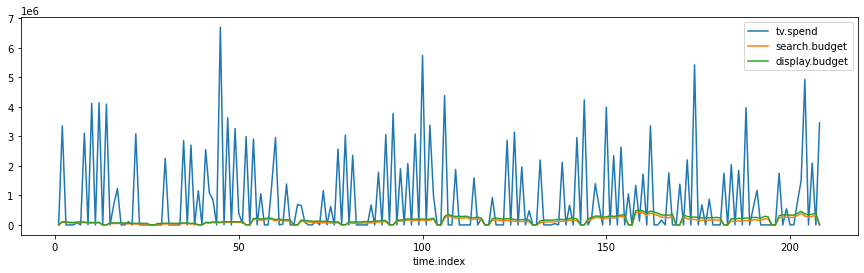

In [ ]:
# create a list including all the features related to marketing spend:
spend = ["tv.spend", "search.budget", "display.budget"]

# calculate weekly total spend for each type of budget
data.groupby("time.index").sum()[spend].plot(figsize=(15, 4))
plt.show()


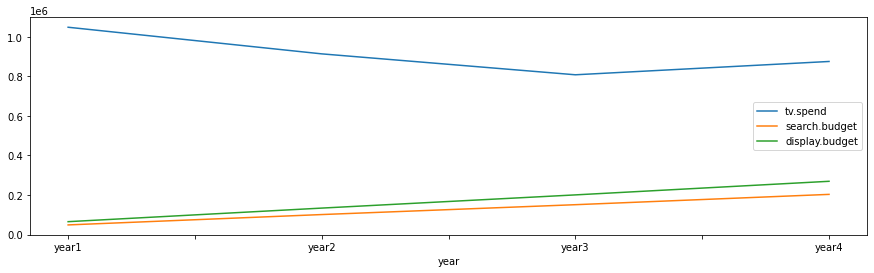

In [ ]:
# create a list including all the features related to marketing spend:
spend = ["tv.spend", "search.budget", "display.budget"]

# calculate weekly total spend for each type of budget
data.groupby("year").mean()[spend].plot(figsize=(15, 4))
plt.show()


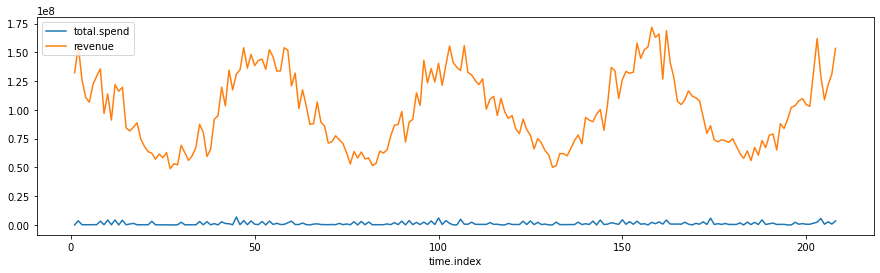

In [ ]:
# create a list including all the features related to marketing spend:
spend_total = ["total.spend", "revenue"]

# calculate weekly total spend for each type of budget
data.groupby("time.index").sum()[spend_total].plot(figsize=(15, 4))
plt.show()

We calculated fiancials such as yeary revenue, current mix in investment, ROI per marketing activity to be able to compare with our recommendation.

In [ ]:
#Calculation of financials:ROI yearly and 4 year horizon
spend2 = ["tv.spend", "search.budget", "display.budget","total.spend","revenue"]
ROI = data.groupby("year").sum()[spend2]
ROI['tv_%']=ROI['tv.spend']/ROI['total.spend']*100
ROI['search_%']=ROI['search.budget']/ROI['total.spend']*100
ROI['display_%']=ROI['display.budget']/ROI['total.spend']*100
ROI['rev_change']= ROI['revenue'].diff()
ROI['ROI_tv']=(ROI['rev_change']-ROI['tv.spend'])/ROI['tv.spend']*100
ROI['ROI_search']=(ROI['rev_change']-ROI['search.budget'])/ROI['search.budget']*100
ROI['ROI_display']=(ROI['rev_change']-ROI['display.budget'])/ROI['display.budget']*100
round(ROI)



,tv.spend,search.budget,display.budget,total.spend,revenue,tv_%,search_%,display_%,rev_change,ROI_tv,ROI_search,ROI_display
year,,,,,,,,,,,,
year1,54499999,2524464,3377313,60380513,5081509360,90.0,4.0,6.0,NaN,NaN,NaN,NaN
year2,47500000,5248664,6948289,59676757,5164219360,80.0,9.0,12.0,82710000.0,74.0,1476.0,1090.0
year3,42000000,7841477,10419400,60247717,5222981360,70.0,13.0,17.0,58762000.0,40.0,649.0,464.0
year4,45499999,10554258,13994459,70041474,5322277520,65.0,15.0,20.0,99296160.0,118.0,841.0,610.0


In [ ]:
#3 year ROI for tv spend
print('tv spend:',(ROI['revenue'][3]-ROI['revenue'][0]-ROI['tv.spend'][1:3].sum())/ROI['tv.spend'][1:3].sum()*100)
print('search spend:',(ROI['revenue'][3]-ROI['revenue'][0]-ROI['display.budget'][1:3].sum())/ROI['display.budget'][1:3].sum()*100)
print('display spend:',(ROI['revenue'][3]-ROI['revenue'][0]-ROI['search.budget'][1:3].sum())/ROI['search.budget'][1:3].sum()*100)

tv spend: 169.01470391061451
search spend: 1286.2993516293388
display spend: 1739.309141131482


In [ ]:
#total mix of investment
print('tv spend:', ROI['tv.spend'].sum()/ROI['total.spend'].sum()*100)
print('search spend:',ROI['search.budget'].sum()/ROI['total.spend'].sum()*100)
print('display spend:',ROI['display.budget'].sum()/ROI['total.spend'].sum()*100)

tv spend: 75.69509760315725
search spend: 10.453058891054186
display spend: 13.876553661367716


We create different possibilities of mixes with starting point as the weighted average [58, 20, 22] of 4 years. Scenarios include 5pp fluctuations for each variable.

In [ ]:
#creating different mixes of investment : 
mix = [[58, 20, 22], [63, 20, 17], [68, 20,12],[53, 20, 27],[48, 20, 32],[63, 15, 22], [68, 10,22],[53, 25, 22],[48, 30, 22],
       [58, 25,17],[58, 30,12],[58, 15,27],[58, 10,32],[53, 25,22],[48, 30,22],[63, 15,22],[68, 10,22],
       [58, 15,27],[58, 10,32],[58, 25,17],[58, 30,12],[53, 20,27],[48, 20,32],[63, 20,17],[68, 20,12]]
  
# Create the pandas DataFrame 
df_mix = pd.DataFrame(mix, columns = ['tv_%', 'search_%','display_%']) 
df_mix = df_mix.drop_duplicates(subset=None, keep='first', inplace=False)

Allocating last year (year4) investment to different mixes applied.

In [ ]:

#If the budget remains the same as in year 4 70041474.0
df_to_predict =df_mix*70041474/100/52
df_to_predict.columns=['tv.spend','search.budget','display.budget']
round(df_to_predict)



,tv.spend,search.budget,display.budget
0,781232.0,269390.0,296329.0
1,848579.0,269390.0,228982.0
2,915927.0,269390.0,161634.0
3,713884.0,269390.0,363677.0
4,646537.0,269390.0,431024.0
5,848579.0,202043.0,296329.0
6,915927.0,134695.0,296329.0
7,713884.0,336738.0,296329.0
8,646537.0,404085.0,296329.0
9,781232.0,336738.0,228982.0


Since we have 3 variables with different confidence levels in the model we decided to account for the risk involved in return. We randomly choose 10000 data points with the mean of coefficient of the variable in the model and standard deviation to have multiple outcomes of return with different mixes and calculate mean and the standard deviation.

In [ ]:
#np random 10000 data points with mean of coeffs and std deviation for all the 3 variables
x_mean = 16.2149
x_std = 2.417
x = np.random.normal(loc=x_mean, scale=x_std, size=10000)
y_mean = 127.5573
y_std = 179.851
y=np.random.normal(loc=y_mean, scale=y_std, size=10000)
z_mean = 311.9624
z_std = 231.080
z=np.random.normal(loc=z_mean, scale=z_std, size=10000)

In [ ]:
#trying all compbinations of mixes defined to predict sales
from itertools import product
#list(product(x,df_mix['tv_%']))
#list(product(y,df_mix['search_%']))
#list(product(z,df_mix['display_%']))
l1 = [x[i] * df_to_predict['tv.spend'][0] + y[i] * df_to_predict['search.budget'][0] + z[i] * df_to_predict['display.budget'][0] for i in range(len(x))]

u = []

for j in range(len(df_to_predict)):
  l1 = [x[i] * df_to_predict['tv.spend'][j] + y[i] * df_to_predict['search.budget'][j] + z[i] * df_to_predict['display.budget'][j] for i in range(len(x))]
  u.append([np.mean(l1),np.std(l1)])

#[i[0]*j/100 + i[1]*k/100+ i[2]*l/100 for i in mix for j in l1 for k in l2 for l in l3]
#[x * y for x, df_to_predict['tv.spend'][0])]
#[x * y for x, y in product(y,df_to_predict['search.budget'])]
#[x * y for x, y in product(z,df_to_predict['display.budget'])]

Mean and standard deviation of prediction for 13 possible mixes.

In [ ]:
#range of predictions for 24 different mixes in terms of mean and standard deviation
#u.sort()
u

[[140164204.99459144, 84747628.88643391],
 [120189125.62178396, 72400675.3125059],
 [100214046.24897651, 61621908.80850083],
 [160139284.3673989, 98072259.55233555],
 [180114363.74020633, 112026248.09030573],
 [132550883.01840807, 78407412.77995004],
 [124937561.04222475, 73531189.76991223],
 [147777526.97077474, 92250477.16982615],
 [155390848.94695807, 100656307.24107224],
 [127802447.59796727, 81042530.54971439],
 [115440690.20134316, 82091213.74889031],
 [152525962.39121556, 92637864.32490775],
 [164887719.7878397, 103762862.68373309]]

Calculating sharpe ratio

In [ ]:
#sharpe ratio
sharpe = [s[0]/s[1] for s in u ]
sharpe_df=pd.DataFrame(sharpe)
sharpe_df.columns = ['sharpe']


Spend optimization would be choosing high growth high sharpe ratio outcome, depending on the company profile. For example option 4 shows 75% increase in revenue while the risk associated is not too much.

In [ ]:
#Spend optimization would be choosing highest growth with lowest sharpe ratio or any other option depending on company risk profile
df_predicted = pd.DataFrame(u)
df_predicted.columns = ['mean','std_dev']
df_concat = pd.concat([df_to_predict,df_predicted],axis=1)
df_concat['rev_yearly']=df_concat['mean']*52
df_concat['rev_growth']=df_concat['rev_yearly']/5322277520
df_concat = pd.concat([df_concat,df_mix],axis=1)
df_concat = pd.concat([df_concat,sharpe_df],axis=1)
df_concat.sort_values('sharpe', ascending = False).head(12)

,tv.spend,search.budget,display.budget,mean,std_dev,rev_yearly,rev_growth,tv_%,search_%,display_%,sharpe
6,915926.967692,134695.142308,296329.313077,1.249376e+08,7.353119e+07,6.496753e+09,1.220672,68,10,22,1.699110
5,848579.396538,202042.713462,296329.313077,1.325509e+08,7.840741e+07,6.892646e+09,1.295056,63,15,22,1.690540
1,848579.396538,269390.284615,228981.741923,1.201891e+08,7.240068e+07,6.249835e+09,1.174278,63,20,17,1.660055
0,781231.825385,269390.284615,296329.313077,1.401642e+08,8.474763e+07,7.288539e+09,1.369440,58,20,22,1.653901
11,781231.825385,202042.713462,363676.884231,1.525260e+08,9.263786e+07,7.931350e+09,1.490217,58,15,27,1.646475
3,713884.254231,269390.284615,363676.884231,1.601393e+08,9.807226e+07,8.327243e+09,1.564601,53,20,27,1.632870
2,915926.967692,269390.284615,161634.170769,1.002140e+08,6.162191e+07,5.211130e+09,0.979117,68,20,12,1.626273
4,646536.683077,269390.284615,431024.455385,1.801144e+08,1.120262e+08,9.365947e+09,1.759763,48,20,32,1.607787
7,713884.254231,336737.855769,296329.313077,1.477775e+08,9.225048e+07,7.684431e+09,1.443824,53,25,22,1.601916
12,781231.825385,134695.142308,431024.455385,1.648877e+08,1.037629e+08,8.574161e+09,1.610995,58,10,32,1.589082


103762862.68373309

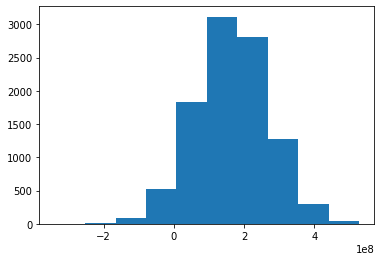

In [ ]:
plt.hist(l1)
np.mean(l1)/np.std(l1)
np.std(l1)